# Patterns of cell-cell communication and transcription factors

Here we will run Tensor-cell2cell v2 to show how our CTCA can be extended to couple  cell-cell communication (CCC) and downstream transcription factor activity. Here we use the tools [cell2cell](https://github.com/earmingol/cell2cell) and [decoupleR-py](https://decoupler-py.readthedocs.io/) to predict CCC and transcription factor activity, respectively.

In this case, we use samples from cortical brain organoids across different time points, previously published on https://doi.org/10.1016/j.stem.2019.08.002.

In [1]:
use_gpu = False

import tensorly as tl
if use_gpu:
    tl.set_backend('pytorch')

**Importing packages to use**

In [2]:
import cell2cell as c2c
import scanpy as sc
import decoupler as dc

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

**IMPORTANT: In this notebook, the version 0.8.0 of cell2cell is used. Older versions do not implement the Coupled Tensor Component Analysis (CTCA).**

## 1 - Load Data

**Specify folders where the data is located, and where the outputs will be written:**

In [4]:
import os

data_folder = './data/'
directory = os.fsencode(data_folder)

output_folder = './results/Tensor-cell2cell/'
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

### RNA-seq data

A preprocessed version of the original paper [(Trujillo et al, 2019)](https://doi.org/10.1016/j.stem.2019.08.002) can be found [here](https://codeocean.com/capsule/9262293/tree/v1/data/preprocessed/annotated_seurat_norm_harmony_2022.h5ad)

In [5]:
rnaseq = sc.read_h5ad(data_folder + '/annotated_seurat_norm_harmony_2022.h5ad')

In [6]:
rnaseq = rnaseq.raw.to_adata()

In [7]:
rnaseq.obs.head(2)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.5,seurat_clusters,celltype,old.ident
Month-01_AAACCTGAGAATTGTG-1,Month-01,6417.0,2431,2.898551,11,11,Other,11
Month-01_AAACCTGAGCAACGGT-1,Month-01,8522.0,2464,2.663694,6,6,Progenitor,6


### Ligand-Receptor pairs

Different databases of ligand-receptor interactions could be used. We previously created a repository that includes many available DBs (https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs). In this tutorial, we employ the ligand-receptor pairs from CellChat (https://doi.org/10.1038/s41467-021-21246-9), which includes multimeric protein complexes.

In [8]:
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
lr_pairs = lr_pairs.astype(str)

In [9]:
lr_pairs.head(2)

,interaction_name,pathway_name,ligand,receptor,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,ligand_symbol,receptor_symbol,ligand_ensembl,receptor_ensembl,interaction_symbol,interaction_ensembl
0,TGFB1_TGFBR1_TGFBR2,TGFb,TGFB1,TGFbR1_R2,TGFb agonist,TGFb antagonist,nan,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB1 - (TGFBR1+TGFBR2),TGFB1,TGFBR1&TGFBR2,ENSG00000105329,ENSG00000106799&ENSG00000163513,TGFB1^TGFBR1&TGFBR2,ENSG00000105329^ENSG00000106799&ENSG00000163513
1,TGFB2_TGFBR1_TGFBR2,TGFb,TGFB2,TGFbR1_R2,TGFb agonist,TGFb antagonist,nan,TGFb inhibition receptor,KEGG: hsa04350,Secreted Signaling,TGFB2 - (TGFBR1+TGFBR2),TGFB2,TGFBR1&TGFBR2,ENSG00000092969,ENSG00000106799&ENSG00000163513,TGFB2^TGFBR1&TGFBR2,ENSG00000092969^ENSG00000106799&ENSG00000163513


In [10]:
# interaction columns:
int_columns = ('ligand_symbol', 'receptor_symbol')

## 2 - Data Preprocessing

### RNA-seq for CCC

**Organize data to create tensor**

First, define contexts

In [11]:
contexts = ['Month-01', 'Month-03', 'Month-06', 'Month-10']

**Generate list of RNA-seq data containing all contexts (time points)**

Here, we convert the single-cell expression levels into cell-type expression levels.
A basic context-wise preprocessing is performed here, keeping only genes that are expressed at least in 4 single cells, and cell types per context with at least 20 cells.

**Important:** A list of aggregated gene expression matrices must be used for building the 4D-communication tensor. Each of the gene expression matrices is for one of the contexts, following the same order as the previouslist (`contexts`).

The aggregation here corresponds to mean expression value across cells of each cell type. Other aggregation methods could be used by changing the parameter ```method='average'``` in the ```aggregate_single_cell()``` function. Additionally, other gene expression values could be passed, using other preprocessing approaches such as log(x+1) or batch correction methods.

In [12]:
rnaseq_matrices = []

for context in tqdm(contexts):
    meta_context = rnaseq.obs.loc[(rnaseq.obs['orig.ident'] == context) \
                                  & (rnaseq.obs['celltype'] != 'Other') & (rnaseq.obs['celltype'] != 'MC')]
    
    # Remove celltype per context that has few single cells
    min_sc_number = 20
    excluded_sc = []
    for idx, row in (meta_context.groupby(['celltype'])[['celltype']].count() >= min_sc_number).iterrows():
        if ~row['celltype']:
            excluded_sc.append(idx)
        
    meta_context = meta_context.loc[~meta_context['celltype'].isin(excluded_sc)]
    cells = list(meta_context.index)

    meta_context.index.name = 'barcode'
    tmp_data = rnaseq[cells]
    # Keep genes in each sample with at least 4 single cells expressing it
    sc.pp.filter_genes(tmp_data, min_cells=4)
    
    # Normalize and Log1p
    sc.pp.normalize_total(tmp_data, target_sum=1e6)
    sc.pp.log1p(tmp_data)

    # Aggregate gene expression of single cells into cell types
    exp_df = c2c.preprocessing.aggregate_single_cells(rnaseq_data=tmp_data.to_df(),
                                                      metadata=meta_context,
                                                      barcode_col='barcode',
                                                      celltype_col='celltype',
                                                      method='average',
                                                     )

    rnaseq_matrices.append(exp_df)

  0%|          | 0/4 [00:00<?, ?it/s]

`rnaseq_matrices` is the list we will use for building the tensor based on protein-based ligand-receptor pairs.

### LR pairs

Remove bidirectionality in the list of protein-based ligand-receptor pairs. That is, remove repeated interactions where both interactions are the same but in different order:

From this list:

| Ligand | Receptor |
| --- | --- |
| Protein A | Protein B |
| Protein B | Protein A |

We will have:

| Ligand | Receptor |
| --- | --- |
| Protein A | Protein B |

In [13]:
lr_pairs = c2c.preprocessing.ppi.remove_ppi_bidirectionality(ppi_data=lr_pairs, 
                                                             interaction_columns=int_columns
                                                             )

Removing bidirectionality of PPI network


In [14]:
lr_pairs.shape

(1988, 17)

**Generate a dictionary with function info for each LR pairs.**

Keys are ***LIGAND_NAME^RECEPTOR_NAME*** (this is the same nomenclature that will be used when building the protein-based 4D-communication tensor later), and values are the function in the annotation column in the dataframe containing ligand-receptor pairs. ***Other functional annotations of the LR pairs could be used if available.***

In [15]:
ppi_functions = dict()

for idx, row in lr_pairs.iterrows():
    ppi_functions[row['interaction_symbol']] = row['annotation']

## 3 - Predict transcription factor activities with DecoupleR

Here, we use the python version of **DecoupleR** to predict Transcription Factor (TF) activities based on their target gene expression, as indicated in [this tutorial](https://decoupler.readthedocs.io/en/latest/notebooks/scell/rna_sc.html#transcription-factor-scoring-from-gene-regulatory-networks).

We start collecting the database linking TFs and their target genes:

In [16]:
collectri = dc.op.collectri(organism="human")
collectri.head()

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation


Then, we processs the single-cell data to obtain gene expression as required for decoupler inputs:

In [17]:
adata = rnaseq.copy()

# Normalize and Log1p
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

**We then proceed to compute the TF activities**

In [18]:
dc.mt.ulm(data=adata, net=collectri)

And gather the activities into a AnnData object:

In [19]:
tf_scores = dc.pp.get_obsm(adata=adata, key="score_ulm")

Similar to the CCC part where we prepared the gene expression data, here we convert the single-cell TF activities into cell-type activity levels.

A basic context-wise preprocessing is performed here, keeping only cell types per context with at least 20 cells.

In [20]:
tf_matrices = []

# This is to keep track of min and max aggregated values per context
max_matrices = pd.DataFrame()
min_matrices = pd.DataFrame()

for context in tqdm(contexts):
    meta_context = rnaseq.obs.loc[(rnaseq.obs['orig.ident'] == context) \
                                  & (rnaseq.obs['celltype'] != 'Other') & (rnaseq.obs['celltype'] != 'MC')]
    
    # Remove celltype per context that has few single cells
    min_sc_number = 20
    excluded_sc = []
    for idx, row in (meta_context.groupby(['celltype'])[['celltype']].count() >= min_sc_number).iterrows():
        if ~row['celltype']:
            excluded_sc.append(idx)
        
    meta_context = meta_context.loc[~meta_context['celltype'].isin(excluded_sc)]
    cells = list(meta_context.index)

    meta_context.index.name = 'barcode'
    tmp_data = tf_scores[cells]

    # Aggregate gene expression of single cells into cell types
    exp_df = c2c.preprocessing.aggregate_single_cells(rnaseq_data=tmp_data.to_df(),
                                                      metadata=meta_context,
                                                      barcode_col='barcode',
                                                      celltype_col='celltype',
                                                      method='average',
                                                     )

    tf_matrices.append(exp_df)
    max_matrices = pd.concat([max_matrices, exp_df.max(axis=1)], axis=1)
    min_matrices = pd.concat([min_matrices, exp_df.min(axis=1)], axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

Once we colected the TF activities (in `tf_matrices`), we proceed to min-max normalize them, so we get the Z-scores in a range of 0 and 1; otherwise these values could not be directly used by Tensor-cell2cell as it requires non-negative values:

In [21]:
tf_activities = [((tf.T - min_matrices.min(axis=1)) / (max_matrices.max(axis=1) - min_matrices.min(axis=1))).T for tf in tf_matrices]

## 4 - Build Tensors

### Build 4D-Communication Tensor

Here we use as input the list of gene expression matrices (`rnaseq_matrices`) that were aggregated into a cell-type granularity. This list contains the expression matrices of all samples/contexts.

The following functions perform all the steps to build a 4D-communication tensor:

![4dtensor](../figures/4d-tensor.png)



The parameter ```communication_score``` indicates the scoring function to use.


```how='outer_cells'``` considers only LR pairs that are present in all contexts, while all cell types in the whole dataset are kept, regardless they appear only in one or a few contexts.

```complex_sep='&'``` is used to specify that the list of ligand-receptor pairs contains protein complexes and that subunits are separated by '&'. If the list does not have complexes, use ```complex_sep=None``` instead.

In [22]:
tensor_lr = c2c.tensor.InteractionTensor(rnaseq_matrices=rnaseq_matrices,
                                         ppi_data=lr_pairs,
                                         context_names=contexts,
                                         how='outer_cells',
                                         complex_sep='&',
                                         interaction_columns=int_columns,
                                         communication_score='expression_gmean',
                                         order_labels=['Contexts', 'Protein LRIs', 'Sender Cells', 'Receiver Cells'],
                                         device='cuda' if use_gpu else 'cpu'
                                        )

Getting expression values for protein complexes
Building tensor for the provided context


In [23]:
tensor_lr.tensor.shape

(4, 422, 5, 5)

### Build 3D TF Activity Tensor

To build our 3D tensor with dimensions as contexts, receiver cells, and transcription factors, we need to make sure that all cell types in the 4D tensor are present in each matrix (for those missing we will assign a NaN value).

We get the list of cell types:

In [24]:
celltypes = tensor_lr.order_names[-1]

Then we reindex all matrices with transcription factors (this will generate missing columns, and fill them with NaNs):

In [25]:
tf_activities_nan = [tf.reindex(columns=celltypes) for tf in tf_activities]

Now we can use these DecoupleR outputs directly to generate our 3D transcription activity tensor. First we generate just the tensor containing the values using tensorly:

In [26]:
tensor_tf_ = tl.tensor(tf_activities_nan)
tensor_tf_.shape

(4, 728, 5)

We then obtain the name of TFs present in the data:

In [27]:
tf_names = tf_activities_nan[0].index.tolist()

Now we take this tensor to generate an `InteractionTensor` object using cell2cell:

In [28]:
tensor_tf = c2c.tensor.PreBuiltTensor(tl.tensor(tf_activities_nan), 
                                      order_names=[contexts, tf_names, celltypes],
                                      order_labels=['Contexts', 'TFs', 'Receiver Cells']
                                     )

In [29]:
tensor_tf.tensor.shape

(4, 728, 5)

## 5 - Generate coupled tensors

Once we have our 4D communication tensor and our 4D TF activity tensor, we start creating a `CoupledInteractionTensor`object in Tensor-cell2cell v2. This object will later perform the CTCA.

For this, we need to specify which dimensions are coupled between each tensor. In our case, the context dimensions are coupled, and both receiver cell dimensions. In this case we asssume that the TF activity occurs in the receiver cells and this activity is related to the LR interactions, so they are *coupled*.

The context dimension is the dim 0 in both tensors, while the receiver cell dimension is dim 3 in the 4D and dim 2 in the 3D tensor:

In [30]:
coupled_tensor = c2c.tensor.CoupledInteractionTensor(tensor1=tensor_lr,
                                                     tensor2=tensor_tf,
                                                     tensor1_name='cell2cell',
                                                     tensor2_name='decoupler',
                                                      # Below we specify how dims of tensor1 are coupled with dims of tensor2
                                                     mode_mapping={'shared' : [(0,0), (3,2)]}
                                                    )

We can observe that this object includes both tensors simultaneously.

In [31]:
coupled_tensor.shape

((4, 422, 5, 5), (4, 728, 5))

**Assume that missing values are real zeros**

Instead of imputing missing values with our method, we will assume that they are real zeros.

In [32]:
coupled_tensor.mask1 = None
coupled_tensor.mask2 = None

## 6 - Run Analysis

### Perform tensor factorization

Next, we apply a tensor decomposition, specifically a non-negative canonical coupled component analysis (CTCA) (same performed in the elbow analysis). Briefly, tensor decomposition identifies a low-rank tensor (here, a rank of 10) for each modality's tensor that  better approximates each original tensor. These low-rank tensors can be represented as the sum of a set of rank-1 tensors (10 of them in this case). Each rank-1 tensor represents a factor in the decomposition and can be further represented as the outer product of n vectors, where n represents the number of tensor dimensions. Each vector represents one of the n tensor dimensions for that factor and its values, corresponding to individual elements in each dimension, represent the factor loadings. 

In the CTCA, we have vectors that are shared between the coupled tensors (here contexts and receiver cells), while we have other vectors that are private for each modality (LR pair and sender cells for the 4D communication tensor; transcription factors for the 3D TF activity tensor). The loadings shared between both tensors behave exactly the same in both modalities, representing that we are capturing LR pairs and TFs from each modality that present similar trends in each factor. If each tensor was decomposed separately with the standard TCA in Tensor-cell2cell v1, we would not ensure that the key LR pair and TFs for each factor would behave the same, as this could lead to loadings for the context and receiver cells with different behaviors between modalities.

To illustrate how performing the CTCA for identifying LR pairs acting coordinated with TF activities, we skipped the Elbow Analysis, which can be found in our [previous tutorial for protein- and metabolite-based LR pairs](../Tensor-cell2cell-CTCA/). Instead, we run the factorization using a manual number of 10 factors:

In [33]:
coupled_tensor.compute_tensor_factorization(rank=10, # This is just for illustrative purposes - to keep a low number of factors
                                            init='svd',
                                            random_state=888,
                                            runs=1, tol=1e-8, n_iter_max=500 # Robust version of tensor decomposition
                                           )

## 7 - Results

### Metadata

**Generate a list containing metadata for each tensor order/dimension - Later used for coloring factor plots**

This is a list containing metadata for each dimension of the tensor (contexts, LR pairs, sender cells, receiver cells). Each metadata corresponds to a dataframe with info of each element in the respective dimension.

We start with the protein-based tensor.

In [35]:
meta_tf = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor_lr,
                                              metadata_dicts=[None, ppi_functions, None, None],
                                              fill_with_order_elements=True
                                             )

We continue with the metabolite-based tensor.

In [36]:
tf_functions = {k: 'TF' for k in tensor_tf.order_names[1]}

In [37]:
meta_tf2 = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor_tf,
                                              metadata_dicts=[None, tf_functions, None],
                                              fill_with_order_elements=True
                                             )

**Generate unified metadata for CTCA results**

By using the metadata generated separately for each tensor, we generate a new metadata that incorporates metadata for the shared and private dimensions between both modalities.

In [38]:
new_meta_tf = coupled_tensor.reorder_metadata(meta_tf, meta_tf2)

**Plot factor loadings**

After performing the CTCA, a set of loadings is obtained in a factor-specific way, for each tensor. These loadings provide details of what elements of each dimension are important within each factor. Here we plot first the loadings for the shared dimensions, followed by the private dimensions of the first and second tensor (LR pairs and TFs, respectively).

In [59]:
# Color palettes for each of the coupled tensor dimensions, ordered as order_sorting list below
cmaps = ['viridis', 'tab20', 'tab20', 'Dark2', 'Dark2']

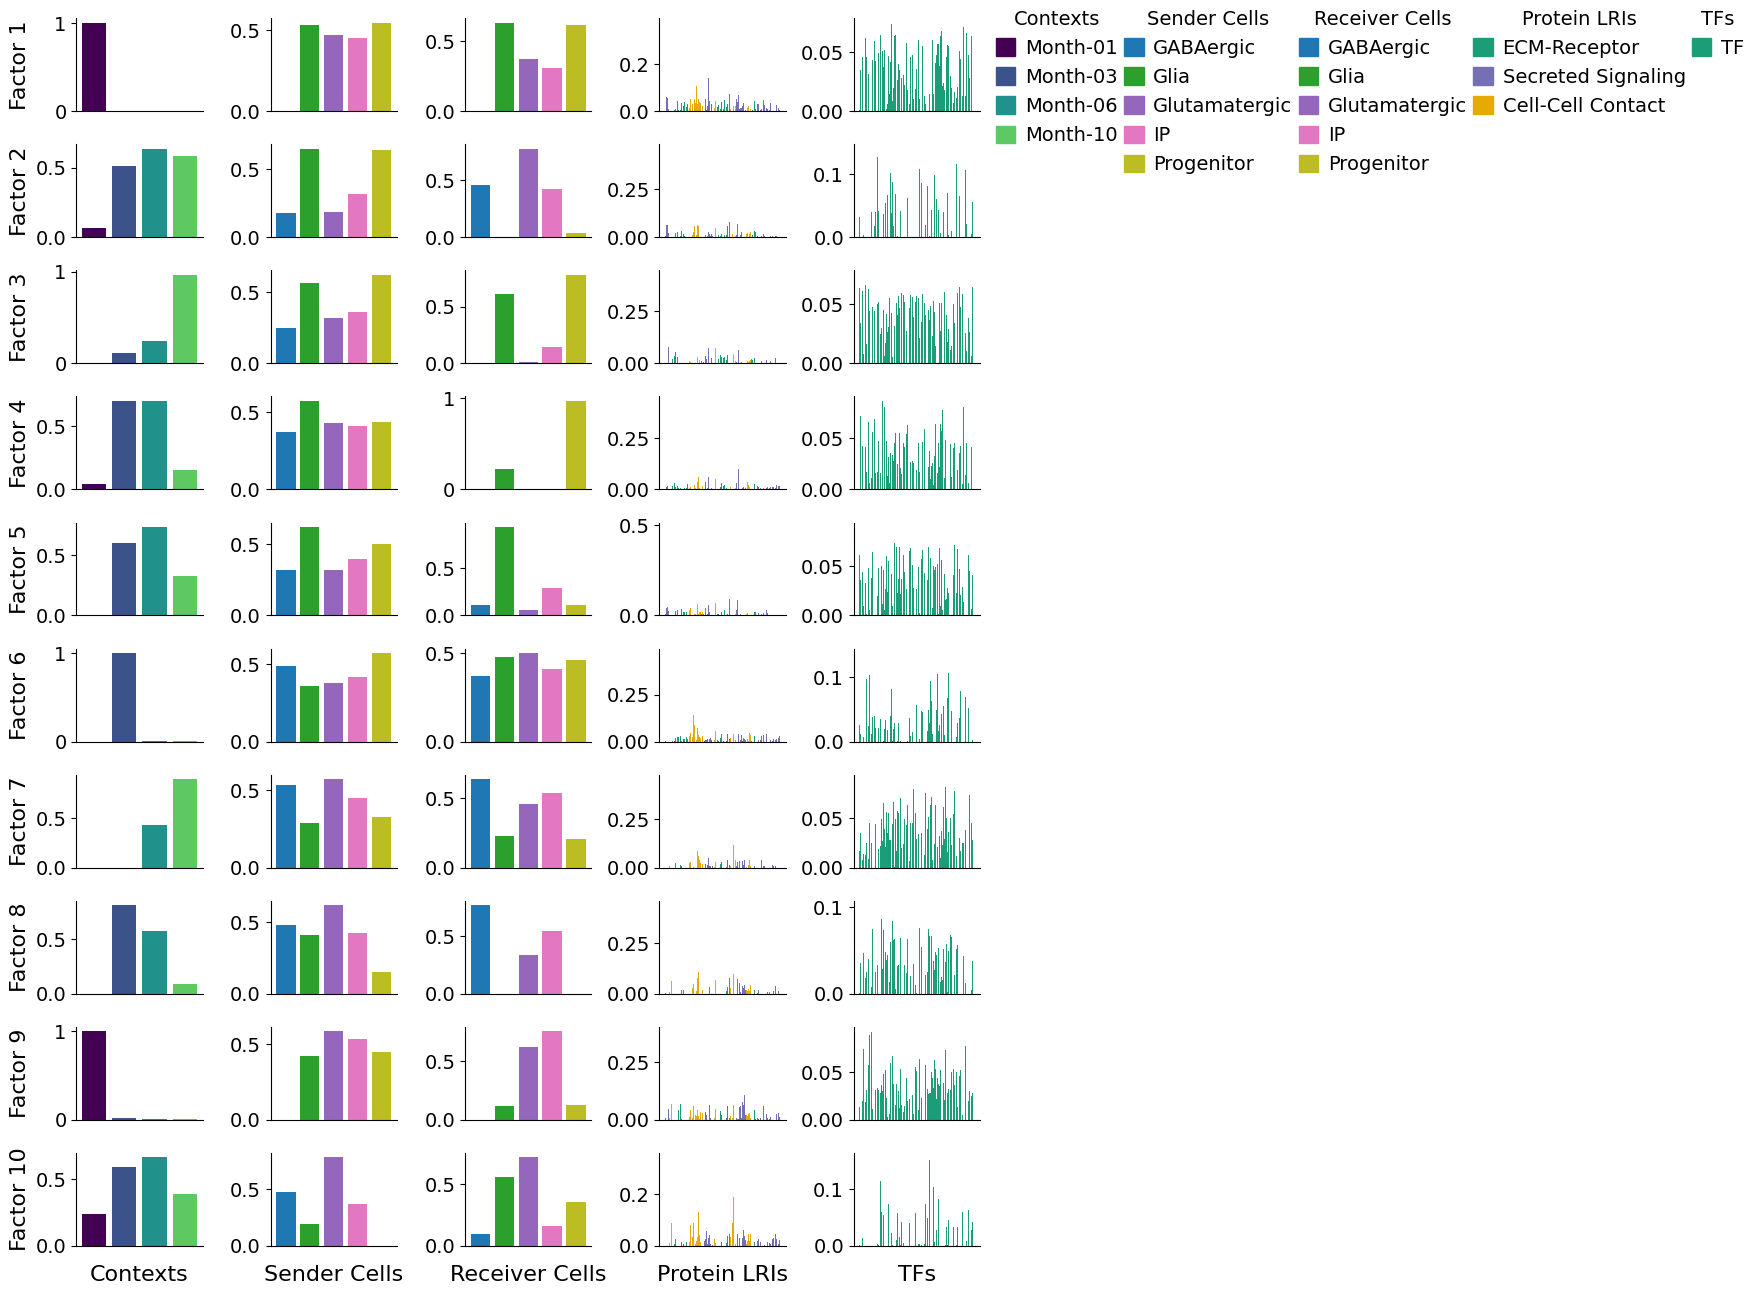

In [60]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=coupled_tensor,
                                                 metadata=new_meta_tf,
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps=cmaps,
                                                 order_sorting=['Contexts', 'Sender Cells', 'Receiver Cells',
                                                                'Protein LRIs', 'TFs'
                                                               ],
                                                 fontsize=14,
                                                 filename=output_folder + 'Tensor-Factorization.pdf'
                                                )

Each factor represents a context-dependent communication pattern. In this visualization, each row is a factor and each column is a tensor dimension in that factor (Shared dimensions: contexts and receiver-cells; Private dimensions: LR pairs, sender-cells, and transcription factors). 

The loadings represent the contribution of each element to that pattern, and their combinations between all dimensions represent the overall pattern. For example, in Factor 1, the identified communication pattern occurs in early stages (month 1), where all cell types but GABAergic neurons participate as sender cells. In particular, the signaling by receiver cells seems linked to glial cells and progenitors. Then we can identify the top LR pairs and TFs contributing from cognate modalities. Thus, we can say that the receptors of these LR pairs act in coordination with the TFs in the receiver cells.

**Top-10 LR pairs**

In [41]:
for i in range(coupled_tensor.rank):
    print(coupled_tensor.get_top_factor_elements('Protein LRIs', 'Factor {}'.format(i+1), 10))
    print('')

MDK^NCL            0.375962
MDK^SDC2           0.333238
CDH2^CDH2          0.298730
CD99^CD99          0.271178
PTN^NCL            0.195146
MDK^ITGA6&ITGB1    0.193094
PTN^SDC2           0.178192
MDK^LRP1           0.167680
GAS6^AXL           0.141274
MDK^SDC4           0.130062
Name: Factor 1, dtype: float64

PTN^NCL        0.456428
MDK^NCL        0.405695
PTN^PTPRZ1     0.393396
MDK^PTPRZ1     0.348121
CD99^CD99      0.200223
MDK^LRP1       0.198023
CDH2^CDH2      0.192796
PTN^SDC3       0.188444
EFNB1^EPHA4    0.089552
NAMPT^INSR     0.088608
Name: Factor 2, dtype: float64

PTN^PTPRZ1    0.422296
MDK^PTPRZ1    0.417957
PTN^NCL       0.288459
MDK^NCL       0.278303
PTN^SDC3      0.261723
CD99^CD99     0.213205
CDH2^CDH2     0.190207
PTN^SDC2      0.181088
MDK^LRP1      0.180837
MDK^SDC2      0.166498
Name: Factor 3, dtype: float64

MDK^SDC2           0.433077
PTN^SDC2           0.414415
PTN^NCL            0.410809
MDK^NCL            0.369739
CD99^CD99          0.324305
CDH2^CDH2     

In [42]:
for i in range(coupled_tensor.rank):
    print(coupled_tensor.get_top_factor_elements('TFs', 'Factor {}'.format(i+1), 5))
    print('')

TBX15    0.074777
HIC1     0.074364
KLF11    0.074121
HES1     0.073807
HOXB2    0.073385
Name: Factor 1, dtype: float64

NEUROD2    0.139475
EOMES      0.126215
GLIS3      0.124213
MESP2      0.121905
SIRT1      0.121780
Name: Factor 2, dtype: float64

HIVEP2    0.074318
MTA1      0.071884
FOXN1     0.071761
GTF2I     0.071450
ESR1      0.070846
Name: Factor 3, dtype: float64

ONECUT1    0.086443
FOXA2      0.086172
PIN1       0.084714
NR4A3      0.082289
TRPS1      0.080464
Name: Factor 4, dtype: float64

NOTCH1    0.089020
MECP2     0.084543
PPARD     0.084321
SALL1     0.082624
RBPJ      0.081430
Name: Factor 5, dtype: float64

ZNF143    0.137734
CTCFL     0.123165
EN1       0.116058
TADA2A    0.112450
HDAC3     0.110000
Name: Factor 6, dtype: float64

MYOCD     0.090057
MBD1      0.088828
RFXANK    0.085337
HCFC1     0.083875
PRDM4     0.083774
Name: Factor 7, dtype: float64

BHLHE41    0.102437
ESRRB      0.097834
SMARCA4    0.097832
ZFHX3      0.095206
RB1        0.095026
Name: 

### Export Loadings

***THESE VALUES CAN BE USED FOR DOWNSTREAM ANALYSES***

In [43]:
coupled_tensor.export_factor_loadings(output_folder + 'Coupled-Loadings.xlsx')

Coupled tensor factor loadings saved to ./results/Tensor-cell2cell/Coupled-Loadings.xlsx


## Downstream Analyses

### Generate factor-specific networks

We can generate factor-specific communication networks connecting sender-to-receiver cells.

In [44]:
networks = c2c.analysis.tensor_downstream.get_factor_specific_ccc_networks(coupled_tensor.factors, 
                                                                           sender_label='Sender Cells',
                                                                           receiver_label='Receiver Cells')

**Generate matrix of cell-cell pairs by factors**

In [45]:
network_by_factors = c2c.analysis.tensor_downstream.flatten_factor_ccc_networks(networks, orderby='receivers')

**Select cell-cell pairs with high potential of interaction**

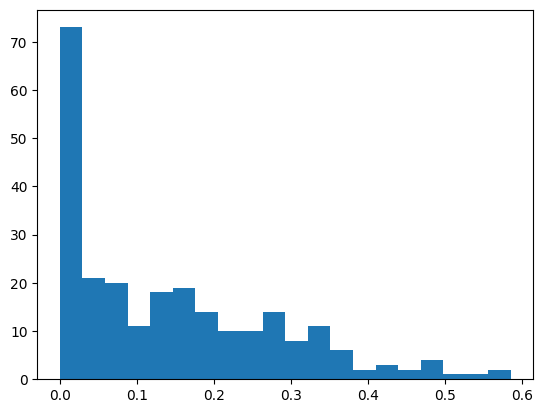

In [46]:
_ = plt.hist(network_by_factors.values.flatten(), bins = 20)

In [47]:
# To consider only cell pairs with high potential to interact in each factor
cci_threshold = 0.2

**Visualize networks of factors with significant differences between groups**

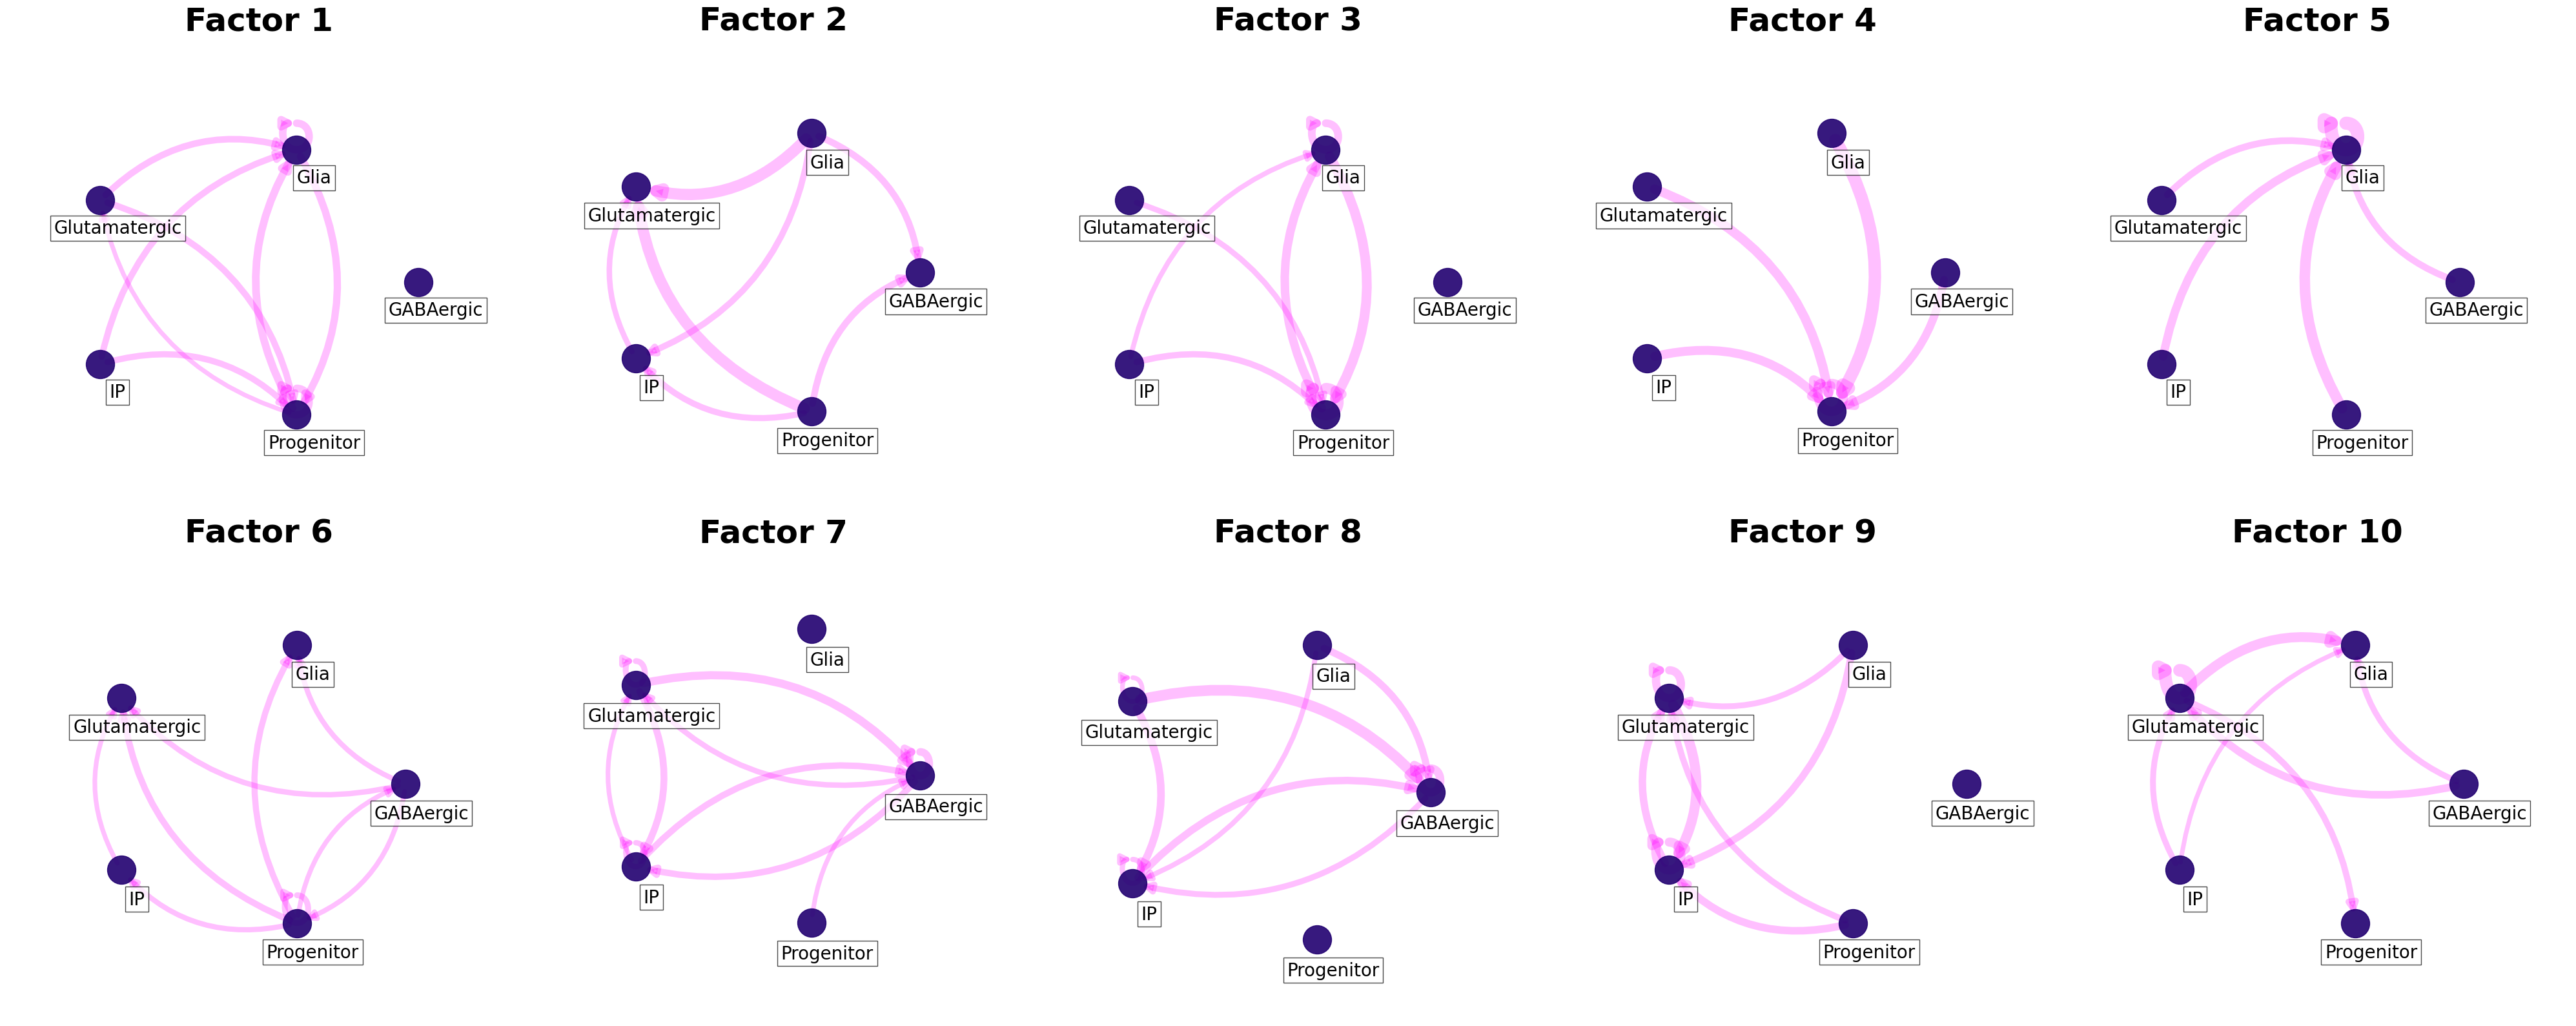

In [48]:
net_fig, net_ax = c2c.plotting.ccc_networks_plot(coupled_tensor.factors,
                                                 included_factors=None,
                                                 ccc_threshold=cci_threshold, # Only important communication
                                                 nrows=2,
                                                 panel_size=(8, 8),
                                                 network_layout='circular',
                                                 filename=output_folder + 'Networks.pdf'
                                                )

### Clustermaps

Similarly, we can visualize the contribution of each dimension element across factors by plotting their loadings

In [49]:
factor_sorted = ['Factor {}'.format(f) for f in range(1, coupled_tensor.rank+1)]

**Cluster cell-cell pairs by their potential across factors**

Here we display the outer product between the sender and receiver cell dimensions, which are the value governing the factor-specific networks above.

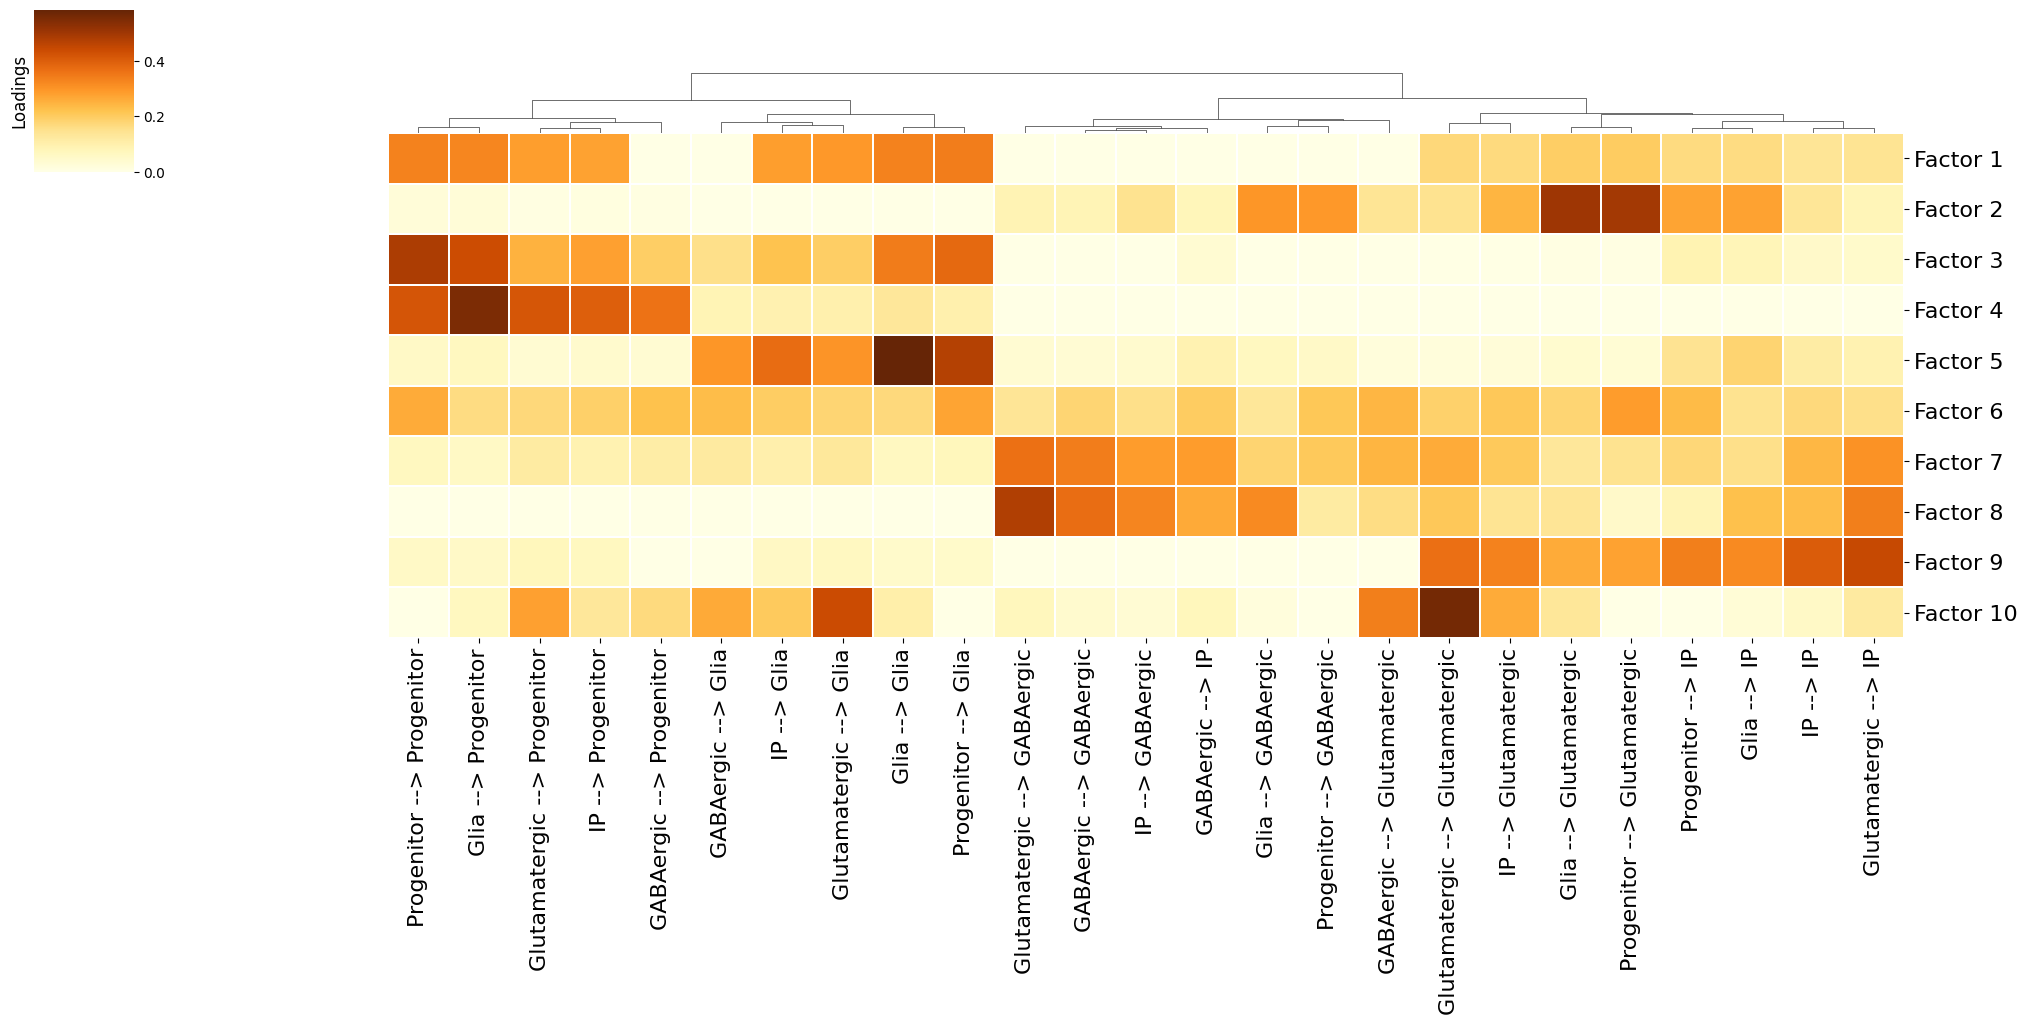

In [50]:
cci_cm = c2c.plotting.loading_clustermap(network_by_factors[factor_sorted],
                                         use_zscore=False, 
                                         loading_threshold=cci_threshold, # To consider relevant CCIs
                                         figsize=(20, 9),
                                         tick_fontsize=16,
                                         cmap='YlOrBr',
                                         filename=output_folder + 'Clustermap-Factor-specific-CCI.pdf',
                                         row_cluster=False
                                        )

**Cluster LR pairs by their importance across factors**

We can plot the key LR pairs from the CCC modality and TFs from the TF activity modality. First we identify what could represent a high loading given their separate distributions.

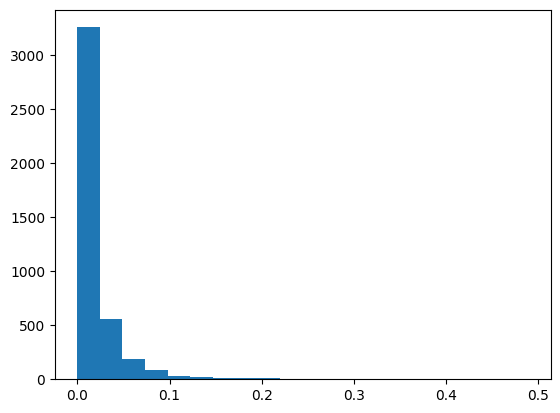

In [51]:
_ = plt.hist(coupled_tensor.factors['Protein LRIs'].values.flatten(), bins = 20)

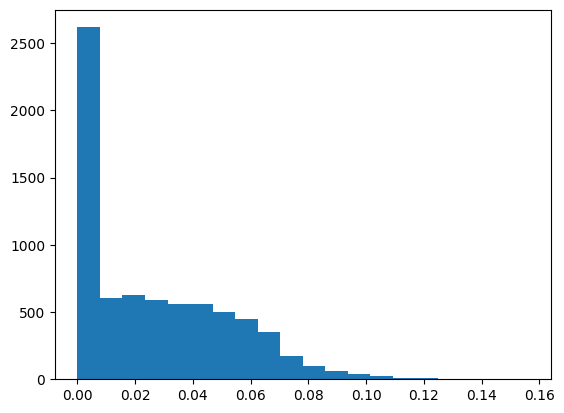

In [52]:
_ = plt.hist(coupled_tensor.factors['TFs'].values.flatten(), bins = 20)

And set and arbitrary threshold to filter out those that have *low loadings*

In [53]:
# To consider only most relevant LR pairs
lr_threshold = 0.1
tf_threshold = 0.1

Since we have loadings from different modalities, we want to visualize them in a comparable way, so we normalize each of them by their maximum value in each case.

In [54]:
df1 = coupled_tensor.factors['Protein LRIs'].copy()
df1 = df1[(df1.T > lr_threshold).any()]
df1 = (df1 / df1.max().max())

df2 = coupled_tensor.factors['TFs'].copy()
df2 = df2[(df2.T > tf_threshold).any()]
df2 = (df2 / df2.max().max())

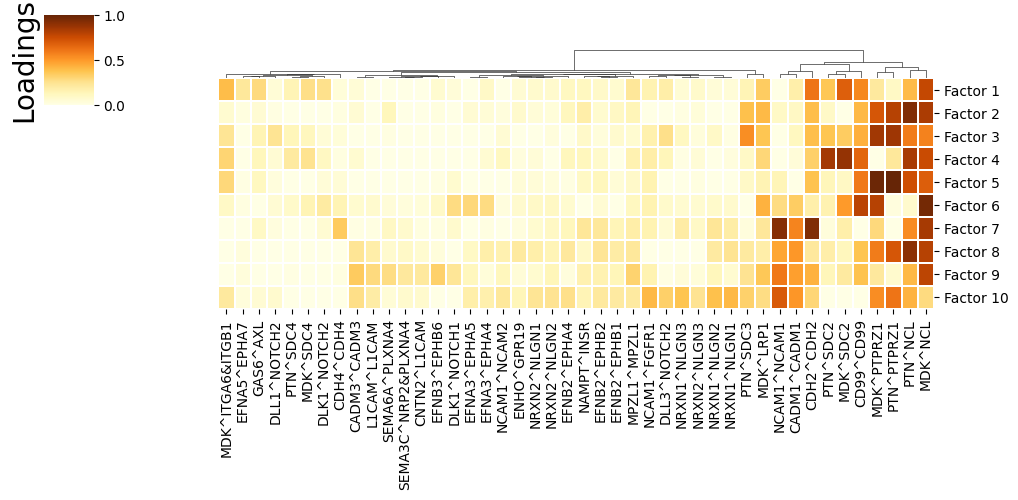

In [55]:
lr_cm = c2c.plotting.loading_clustermap(df1,
                                        loading_threshold=lr_threshold, # To consider only top LRs
                                        use_zscore=False,
                                        figsize=(10, 5),
                                        cbar_fontsize=20,
                                        tick_fontsize=10,
                                        cmap='YlOrBr',
                                        filename=output_folder + 'Clustermap-Factor-specific-ProtLRs.pdf',
                                        row_cluster=False
                                       )

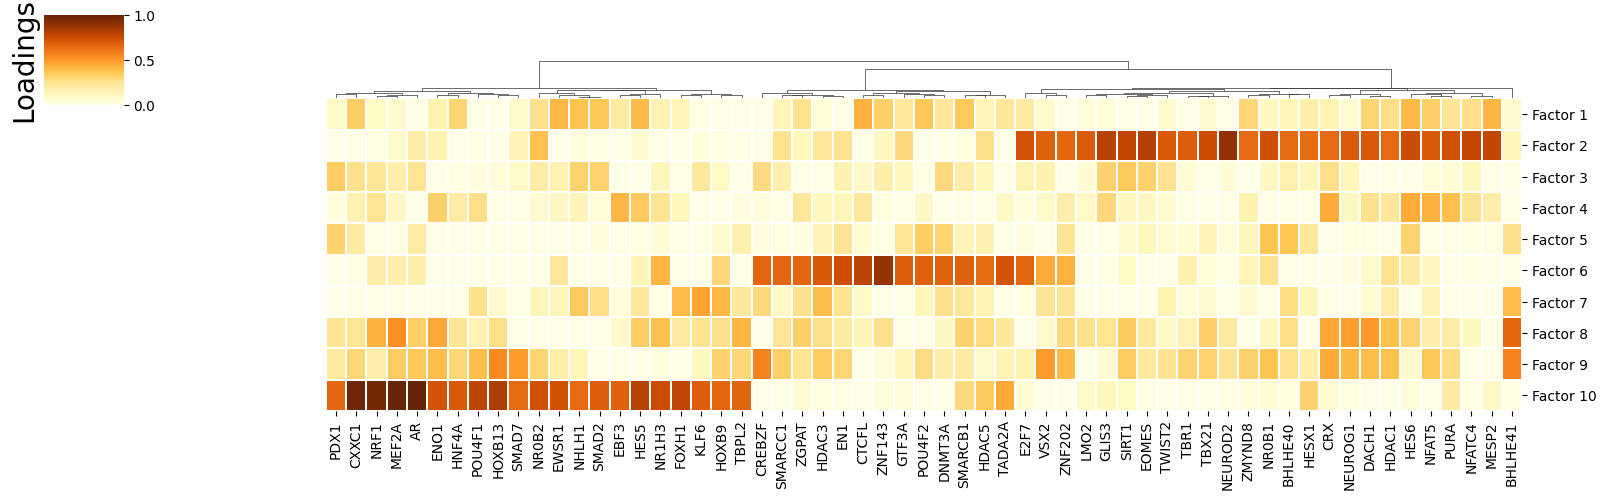

In [56]:
lr_cm = c2c.plotting.loading_clustermap(df2,
                                        loading_threshold=tf_threshold, # To consider only top LRs
                                        use_zscore=False,
                                        figsize=(16, 5),
                                        cbar_fontsize=20,
                                        tick_fontsize=10,
                                        cmap='YlOrBr',
                                        filename=output_folder + 'Clustermap-Factor-specific-TFs.pdf',
                                        row_cluster=False
                                       )

Given that we max-scaled them, we can also put them together in an unified plot

In [57]:
df = pd.concat([df1, df2])

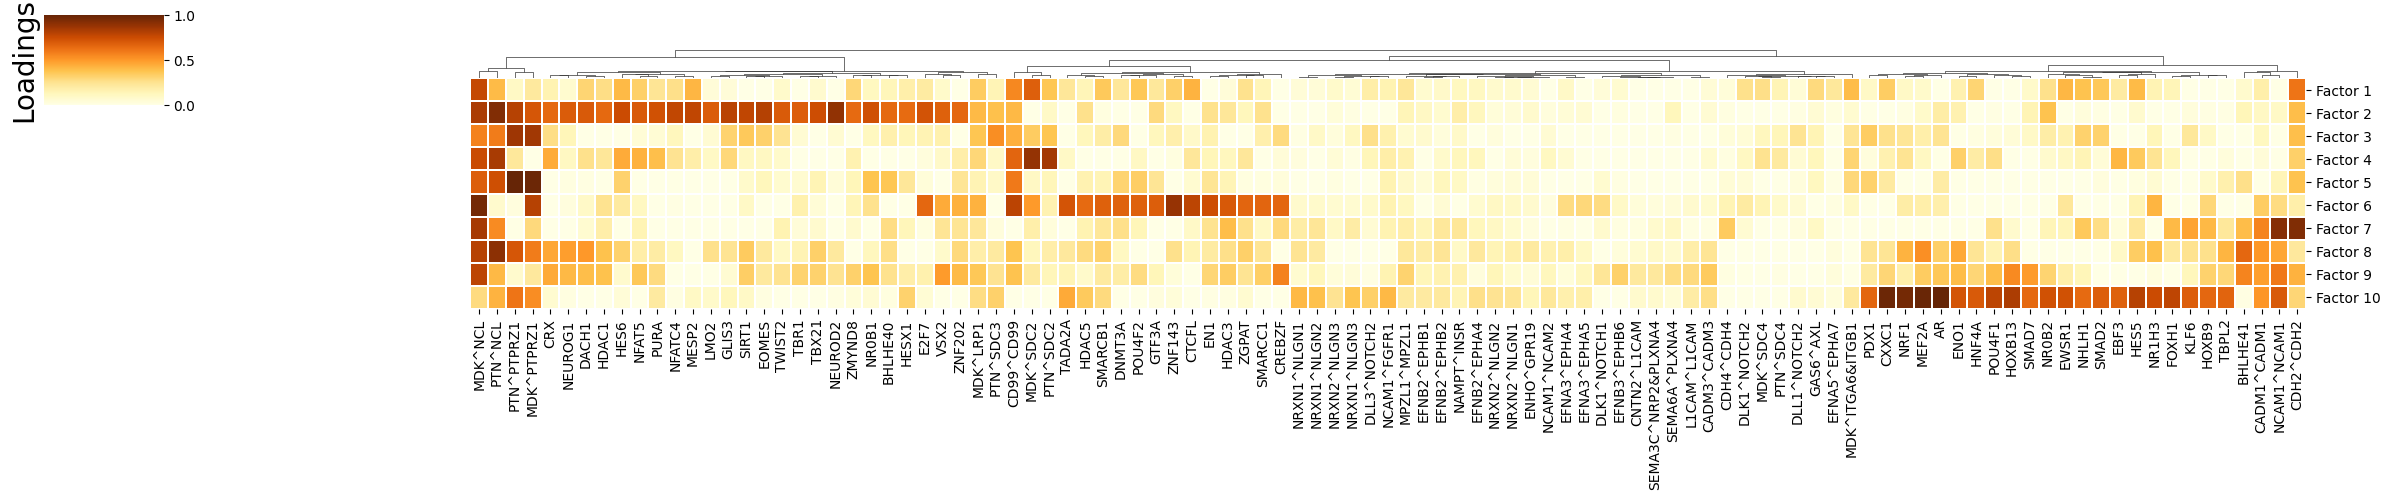

In [58]:
lr_cm = c2c.plotting.loading_clustermap(df,
                                        loading_threshold=0.1, # To consider only top LRs and TFs
                                        use_zscore=False,
                                        figsize=(24, 5),
                                        cbar_fontsize=20,
                                        tick_fontsize=10,
                                        cmap='YlOrBr',
                                        filename=output_folder + 'Clustermap-Factor-specific-LR-TFs.pdf',
                                        row_cluster=False
                                       )